In [1]:
#importing the libraries
import torch
import os
from os import listdir
import torch.optim
import numpy as np
import torch.nn.functional as F
import cv2
import random
import torch.utils.data as data
import torch.nn as nn
import sys
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
%mkdir "test_images"

In [3]:
%cd "/content/drive/MyDrive/1mtech3sem/301/data"

/content/drive/MyDrive/1mtech3sem/301/data


In [4]:
!pwd

/content/drive/MyDrive/1mtech3sem/301/data


In [5]:

seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = torch.device('cuda:{}'.format(0))
    torch.cuda.manual_seed(seed)

else:
    device = torch.device('cpu')
    torch.manual_seed(seed)

In [6]:
device

device(type='cuda', index=0)

In [7]:
#taking the file names of the images
pencil_image_names = [images for images in os.listdir("pencil_drawing")]
pencil_image_names.sort()
input_image_names = [images for images in os.listdir("photo")]
input_image_names.sort()

In [8]:
#pairing the images names
input_output_image_names_pairs = list(zip(input_image_names,pencil_image_names))

print(len(input_output_image_names_pairs))

500


In [9]:
#randomly taking 50 images as test set and remaining as train set

test_indices = random.sample(range(0,500), 50)
train_indices = list(set([i for i in range(0,500)]) - set(test_indices))
train_indices.sort()

In [ ]:
test_indices

In [10]:
test_image_names = [input_output_image_names_pairs[image] for image in test_indices]
test_image_names.sort()

train_image_names = [input_output_image_names_pairs[image] for image in train_indices]
print(len(test_image_names))
#print(len(list(train_image_names)))

#train_image_names = train_image_names[0:50]

print(len(train_image_names))

50
450


In [11]:
#custom dataset class
class Mydataset(data.Dataset):
  
    def __init__(self,phase,file_names):
        
        self.phase = phase
        self.file_names = file_names
  
    def __len__(self):
        return len(self.file_names)

    def __getitem__(self,idx):
        
        input_image_path = self.file_names[idx][0]
        pencil_sketch_image_path = self.file_names[idx][1]  #reading filenames...

        input_image_path = os.path.join("photo",input_image_path)
        pencil_sketch_image_path = os.path.join("pencil_drawing",pencil_sketch_image_path)  #...and adding the folder they are in.

        input_image = cv2.imread(input_image_path)
        pencil_sketch = cv2.imread(pencil_sketch_image_path)    #reading the image

        input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)  #converting bgr to rgb
        pencil_sketch = cv2.cvtColor(pencil_sketch, cv2.COLOR_BGR2RGB) 
        #print("pencil_sketch.ahape",pencil_sketch.shape)
        
        input_image = np.transpose(input_image,axes=(2,0,1))/255    #normalizing the image
        pencil_sketch = np.transpose(pencil_sketch,axes=(2,0,1))/255
        #print("pencil_sketch.ahape",pencil_sketch.shape)

        input_image = torch.from_numpy(input_image).float()     #converting to float
        pencil_sketch = torch.from_numpy(pencil_sketch).float()
        #print("pencil_sketch.ahape",pencil_sketch.shape)
        
        
        return input_image, pencil_sketch, idx 

    def __get_file_name__(self,idx):

      return self.file_names[idx][0],self.file_names[idx][1]

In [12]:
#datasets for train and test
train_dataset = Mydataset(phase = 'train', file_names=train_image_names)  
test_dataset = Mydataset(phase = 'test', file_names=test_image_names) 

In [13]:
batch_size = 1
num_workers = 1

In [14]:
#dataloaders for test and train
train_loader = data.DataLoader(train_dataset,batch_size = batch_size,num_workers = num_workers,drop_last=True,shuffle = True) 
test_loader = data.DataLoader(test_dataset,batch_size = batch_size,num_workers = num_workers,shuffle = False)


In [15]:
#initializing all the convolution layers weights as he initialization.
def init_weights_kaiming_he(m):
    with torch.no_grad():
        if type(m) == nn.Conv2d:
            torch.nn.init.kaiming_uniform_(m.weight)

In [16]:
#defining adaptive batch normalization layer as per papaer  i.e linear ccombination of identity map and batch norm
class AdaptiveBatchNorm(nn.Module):

    def __init__(self, num_features):
        
        super(AdaptiveBatchNorm,self).__init__()
        
        self.bn = nn.BatchNorm2d(num_features)
        self.lamda = nn.Parameter(torch.ones(1, 1, 1, 1)) #4 ones for (batchsize,channel,length,width) of image
        self.mu = nn.Parameter(torch.zeros(1, 1, 1, 1))

    def forward(self, x):
        
        return self.lamda * x + self.mu * self.bn(x)

In [17]:
#defining the intermedaite layer in the architecture

class IntermediateLayer(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1,dilation=1):
        
        super(IntermediateLayer,self).__init__()

        padding = dilation * (kernel_size - 1) // 2
        
        self.layer =  nn.Sequential(  nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding,dilation=dilation, bias=True),
                                      AdaptiveBatchNorm(out_planes),
                                      nn.LeakyReLU(negative_slope=0.2, inplace=True)
                      )
        
        self.apply(init_weights_kaiming_he)

    def forward(self,x):

        return self.layer(x)


In [18]:
class Model(nn.Module):
    
    def __init__(self,d=9,w=24):
        
        super(Model,self).__init__()
        
        self.archi_depth = d
        self.feature_depth = w

        layers=[]
        in_planes=3
        dilation=1
        
        for i in range(0,self.archi_depth-2):
            
            layers.append(IntermediateLayer(in_planes,self.feature_depth,dilation=dilation))
            in_planes=w
            dilation*=2
        
        layers.append(IntermediateLayer(w,w))   #this is defined outside the loop since it doesn't have dilation(in model architecture) 
        layers.append(nn.Conv2d(in_channels = w, out_channels = 3, kernel_size = 1)) #output layer has no nonlinearity 
        
        self.conv=nn.Sequential(*layers)
        self.apply(init_weights_kaiming_he)

    def forward(self,x):

        return self.conv(x)

In [26]:
def train(model,optimizer,epoch,train_loader,loss_fun,batch_wise_loss,epoch_wise_loss):
    model.train()
    overall_epoch_loss = 0.0
    for i, (input_image, pencil_sketch, idx) in enumerate(train_loader):

      input_image = input_image.to(device)
      pencil_sketch = pencil_sketch.to(device)

      output_image = model(input_image)

      loss = loss_fun(output_image,pencil_sketch)

      #print("loss")
      batch_wise_loss.append(loss.item())
      overall_epoch_loss += loss.item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    print(f"loss in this epoch {epoch} is :"+str(overall_epoch_loss))
    epoch_wise_loss.append(overall_epoch_loss)
    return model,optimizer,batch_wise_loss,epoch_wise_loss


In [20]:
def psnr_loss(sloss_fun,x,y):
    return 20*torch.log10(torch.max(x)) - 10*torch.log10(loss_fun(x,y))

In [21]:
def save_image(img,idx,iter):
  #print(img.shape)
  img = img.numpy().transpose(1,2,0)*255
  #print(img.shape)
  img = np.clip(img,0,255)
  name2 = test_dataset.__get_file_name__(idx)
  name2 = name2[1].split("/")[-1]
  name = "/content/test_images/" + name2 
  cv2_imshow(img)
  cv2.imwrite(name,img)
  print(name2)


In [22]:
def test(model,test_loader,loss_fun,psnr_losses,losses):
    
    model.eval()
    overall_epoch_loss = 0.0
    overall_psnr_loss_for_epoch = 0.0
    with torch.no_grad():
        for i, (input_image, pencil_sketch, idx) in enumerate(test_loader):
            input_image = input_image.to(device)
            pencil_sketch = pencil_sketch.to(device)

            output_image = model(input_image)
            print(output_image.shape)
            save_image(output_image.squeeze(0).cpu().detach(),idx,i)
            loss = loss_fun(output_image,pencil_sketch)
            loss2 = psnr_loss(loss_fun,output_image,pencil_sketch)
            
            overall_epoch_loss += loss.item()
            overall_psnr_loss_for_epoch += loss2.item()
            psnr_losses.append(loss2)
            losses.append(loss)

    print("total loss is :"+str(overall_epoch_loss))
    print(f"psnr_loss for full batch is : {overall_psnr_loss_for_epoch}")
    return overall_epoch_loss,psnr_losses,losses

In [24]:
batch_wise_loss = []
epoch_wise_loss = []

In [28]:
my_model = Model()

my_model = my_model.to(device)

optimizer = torch.optim.Adam(my_model.parameters(),lr=0.001)
loss_fun = nn.MSELoss()

n_epochs = 10
for i in range(n_epochs):

    my_model,optimizer,batch_wise_loss,epoch_wise_loss = train(my_model,optimizer,i+1,train_loader,loss_fun,batch_wise_loss,epoch_wise_loss)
    #loss = test(my_model,test_loader,loss_fun)

    #print(f"loss for this epoch is {loss}")

loss in this epoch 1 is :23.851991918869317
loss in this epoch 2 is :9.80005162768066
loss in this epoch 3 is :5.483640617225319
loss in this epoch 4 is :3.9754621745087206
loss in this epoch 5 is :3.075429738499224
loss in this epoch 6 is :2.298265744931996
loss in this epoch 7 is :2.0609190508257598
loss in this epoch 8 is :1.7365675382316113
loss in this epoch 9 is :1.6828146913321689
loss in this epoch 10 is :1.4679388783406466


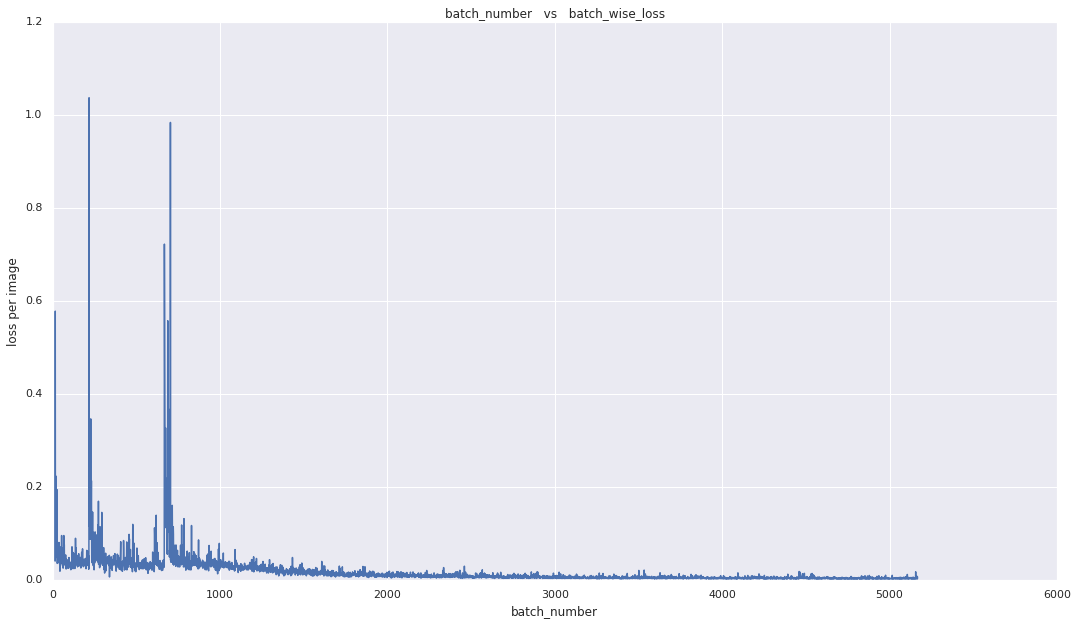

In [37]:
x_axis = [i for i in range(len(batch_wise_loss))]
plt.figure(figsize=(18 , 10))
plt.title("batch_number   vs   batch_wise_loss")
plt.xlabel("batch_number")
plt.ylabel("loss per image")
plt.plot(x_axis,batch_wise_loss)

In [32]:
epoch_wise_loss

[21.436177506111562,
 23.851991918869317,
 9.80005162768066,
 5.483640617225319,
 3.9754621745087206,
 3.075429738499224,
 2.298265744931996,
 2.0609190508257598,
 1.7365675382316113,
 1.6828146913321689,
 1.4679388783406466]

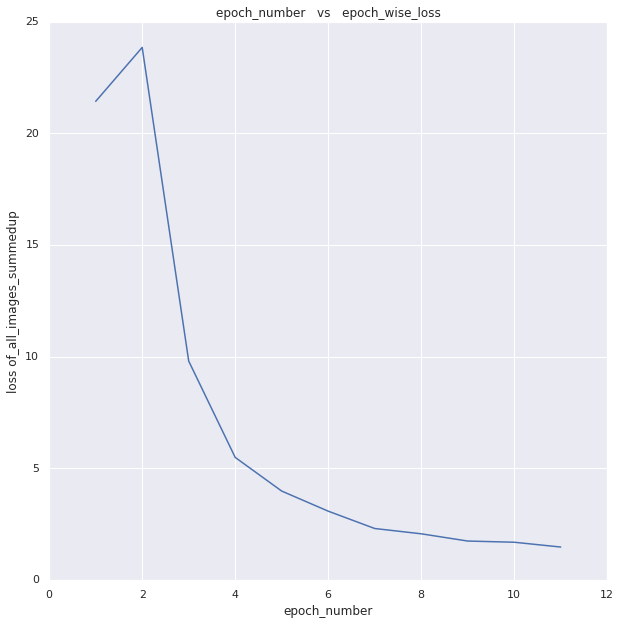

In [38]:
x_axis2 = [i+1 for i in range(len(epoch_wise_loss))]
plt.figure(figsize=(10 , 10))
plt.title("epoch_number   vs   epoch_wise_loss")
plt.xlabel("epoch_number")
plt.ylabel("loss of_all_images_summedup")
plt.plot(x_axis2,epoch_wise_loss)

In [105]:
def display_four_images(model,test_loader):
    
    model.eval()
    val = 5
    count = 1
    #print(random_indices)
    #plt.subplot(1, 4)
    rows = 4
    cols =3
    fig = plt.figure(figsize=(10, 20))
    with torch.no_grad():
        for i, (input_image, pencil_sketch, idx) in enumerate(test_loader):
            #print(idx)
            
            if(val == 9):
              break
            if(i == val):
              val+=1
              input_image = input_image.to(device)
              pencil_sketch = pencil_sketch.to(device)

              output_image = model(input_image)
              
              fig.add_subplot(rows, cols, count)
              count+=1
              img  = input_image.squeeze(0).cpu().detach()
              img = img.numpy().transpose(1,2,0)
              img = np.clip(img,0,1)
              #plt.figure(figsize=(5 , 5))
              plt.imshow(img)
              plt.title("original_image")
              plt.axis('off')
              
              fig.add_subplot(rows, cols, count)
              count+=1
              img  = pencil_sketch.squeeze(0).cpu().detach()
              img = img.numpy().transpose(1,2,0)
              img = np.clip(img,0,1)
              #plt.figure(figsize=(5 , 5))
              plt.imshow(img)
              plt.title("ground_truth")
              plt.axis('off')
              
              fig.add_subplot(rows, cols, count)
              count+=1
              img  = output_image.squeeze(0).cpu().detach()
              img = img.numpy().transpose(1,2,0)#*255
              #print(img.shape)
              img = np.clip(img,0,1)
              #plt.figure(figsize=(5 , 5))
              plt.imshow(img)
              plt.title("output_image")
              plt.axis('off')
            
        plt.show()

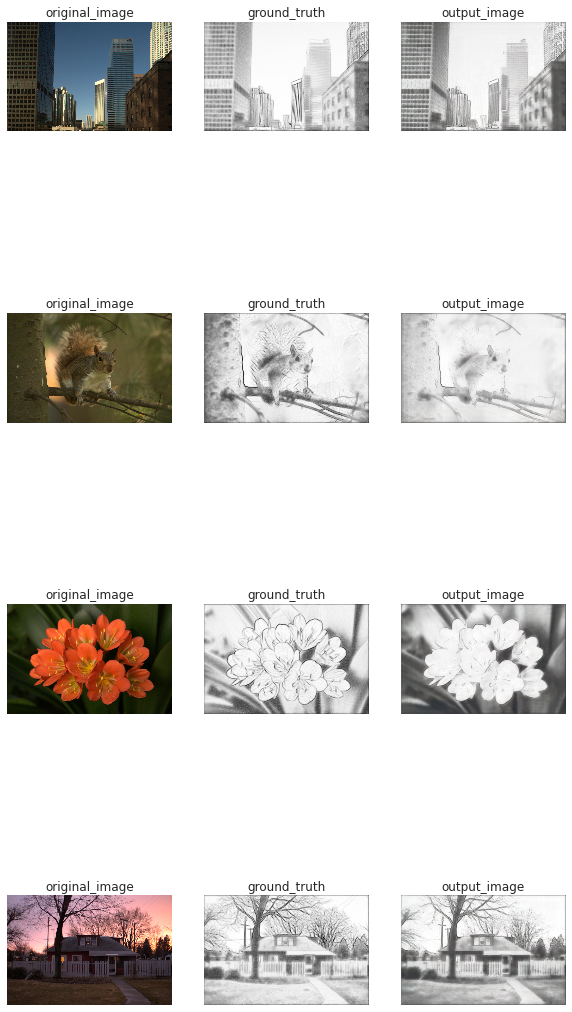

In [106]:
random_indices = random.sample(test_indices , 4)
display_four_images(my_model,test_loader)

In [36]:
test(my_model,test_loader,loss_fun)  #learning from all images(450) and gave output on 50 test images 

Output hidden; open in https://colab.research.google.com to view.

In [31]:
test(my_model,test_loader,loss_fun)  #trained on random 50 images and tested on another random 50 images for 20epochs as trail

Output hidden; open in https://colab.research.google.com to view.